In [31]:
%load_ext autoreload
%autoreload 2


import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.


import seaborn as sns
import os
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

import numpy as np
import tensorflow as tf
from tensorflow import keras

%env WANDB_SILENT=true
import wandb
import logging

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


In [32]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *

In [33]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegression'

predict_n = 10

In [34]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.619962,0.394439,0.596761,0.496869,higher,0.012863,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.619512,0.394997,0.595125,0.477865,lower,0.013540,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.619054,0.395653,0.594787,0.474037,higher,0.013508,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.618669,0.396346,0.594843,0.474674,lower,0.013540,higher
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.617898,0.397285,0.592643,0.449242,lower,0.013666,higher


In [35]:
y_column = 'NextPrice'
seq_len = 5
n_splits=10
val_size = 0.2

features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 
            'EMA(14)', 'SMA(10)', 'SMA(20) - SMA(10)','PercentageDiff', 'LowLen', 'RSI_diff', 'BodyLen', 'Volume_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(10, 6)

In [36]:
import wandb
from wandb.keras import WandbCallback

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [37]:
import tensorflow as tf
from models.keras_lstm_model import LSTMModel

model = LSTMModel(config_dict, inputs, learning_rate=config_dict['learning_rate'], loss='mse')

MSE : 1.0875537380223042e-05


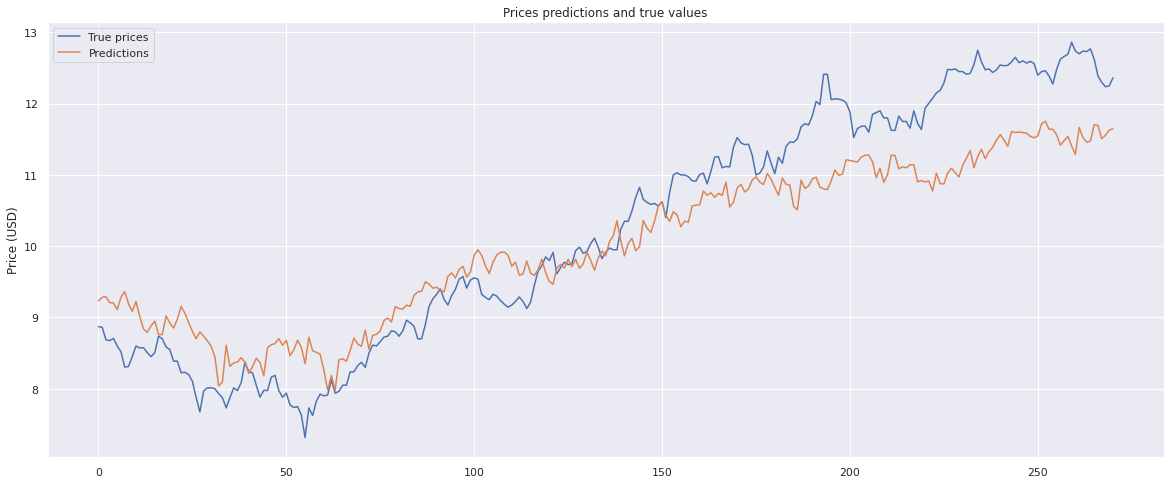

In [51]:
from sklearn.metrics import mean_squared_error
from Plots import *
def test_model(model, test_set, log_wandb=False):
    predictions = np.array([])
    labels = np.array([])

    for x, y in test_set:
        predictions = np.concatenate([predictions, model.predict(x).flatten()])
        labels = np.concatenate([labels,y])
    
    print(f"MSE : {mean_squared_error(y_pred=predictions, y_true=labels)}")
       
    
    scaled_preds = data_wrapper.get_unscaled_values(predictions, 'Close')
    scaled_labels = data_wrapper.get_unscaled_values(labels, 'Close')
    
    ax = plot_predictions(scaled_labels, scaled_preds)
    
    if log_wandb:
        wandb.log({"Unscaled prices and labels":wandb.Image(plt)})
        plt.close()
    else:
        plt.show()
        
test_model(model, val_set, log_wandb=False)

In [41]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds

config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 50,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    for batch in train_set.take(1):
        inputs, targets = batch
        

    model = LSTMModel(config_dict, inputs, learning_rate=config_dict['learning_rate'], loss='mse')
    model = model.model
    history = model.fit(train_set, validation_data=val_set, epochs=config_dict['n_epochs'], 
                        shuffle=False, verbose=0, callbacks=[WandbCallback()])
    #wandb.log({'train_loss': history.history['loss'], 'val_loss':history.history['val_loss']})
    test_model(model, val_set, log_wandb=True)

    run.finish()

0it [00:00, ?it/s]

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


MSE : 1.0875537380223042e-05


NameError: name 'get_unscaled_series' is not defined

### Train a model with the full training set (train + validation) 

In [11]:
%env WANDB_SILENT=True

full_train_set = train_set.concatenate(val_set)
run = wandb.init(project='StockRegressionKerasLSTM', group=group_name, name=f"Full training set")
final_model = build_model(inputs, learning_rate=config_dict['learning_rate'], loss='mse')
history = final_model.fit(full_train_set, epochs=100, shuffle=False, verbose=0, callbacks=[WandbCallback()])
run.finish()

env: WANDB_SILENT=True


epoch,99
loss,0.00261
_runtime,127
_timestamp,1620369017
_step,99


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▄▄▅▃▃▃▂▂▂▁▂▂▂▂▁▁▁▁▂▂▄▅▅▇▇██▇▇██▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


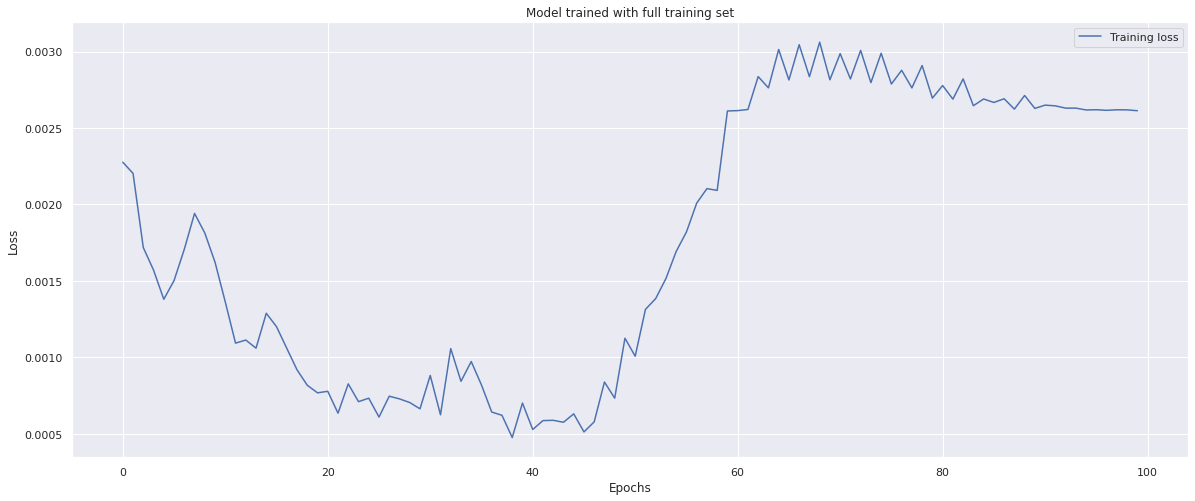

MSE : 0.034736392662961225


Error: You must call wandb.init() before wandb.log()

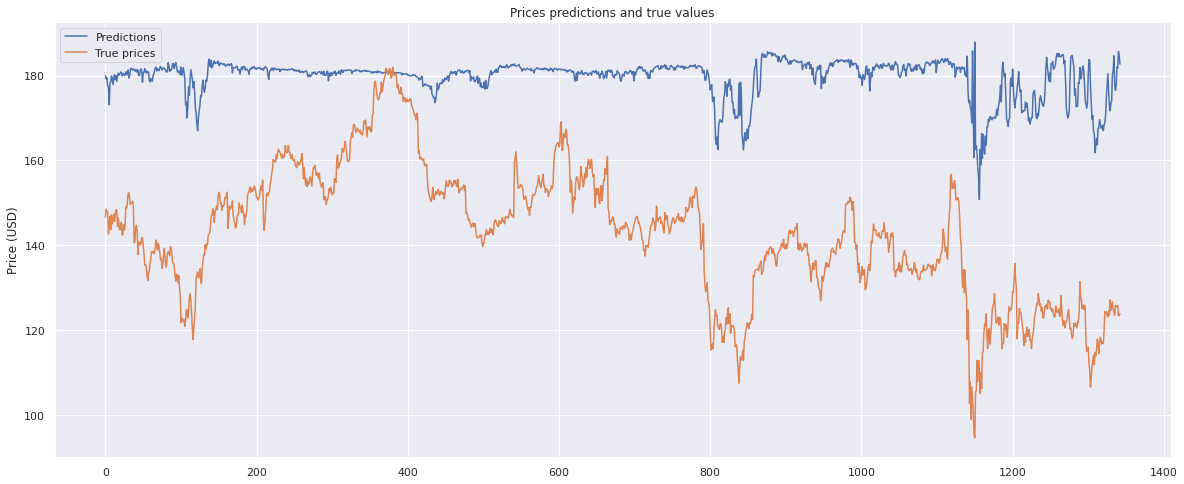

In [12]:
visualize_loss(history, f"Model trained with full training set")
test_model(final_model, test_set, log_wandb=True)

In [ ]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in train_set], axis=0)
training_labels = np.concatenate([y for x, y in train_set], axis=0)

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=X_train,
                                                   verbose=True, mode='regression')

In [ ]:
test_samples = np.concatenate([x for x, y in val_set], axis=0)

print(test_samples.shape)

In [ ]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, training_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

In [ ]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

#[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]